In [92]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import imutils
import scipy.stats as stats

In [93]:
## Ne garder que les images non câblées

liste_non_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

## Ne garder que les images câblées

liste_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))


In [ ]:
def mires(img_input, draw = False):
    
    assert img_input is not None, "file could not be read, check with os.path.exists()" #Vérifier si l'image existe

    img = cv.cvtColor(img_input,cv.COLOR_BGR2GRAY) #Mettre en noir et blanc

    (height,length) = img.shape

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    sliceparams = [(100, 400, 300, 600, 1),  
                   (-400, -100, 300, 600, 1),
                   (3800, 4200, 500, 800, 2), 
                   (100, 400, -600,-300, 1), 
                   (-400, -100, -600, -300, 1), 
                   (3800, 4200, -800, -500, 2)]

    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR) #Avec 3 canaux pour pouvoir l'afficher bien

    centers = []

    for (beg1, end1, beg2, end2, nbmires) in sliceparams :
        mask = img[beg1:end1, beg2:end2]

        #Blur pour réduire le bruit
        mask = cv.medianBlur(mask,5)
        #Fonction qui détecte les cercles. Trouve un seul cercle ou deux à chaque fois en fonction de nbmires
        circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 100,
                                    param1=50,param2=20,minRadius=20 ,maxRadius=30)

        if circles is not None:
            circles = np.int16(np.around(circles))
            for i in circles[0,:nbmires]:
                
                centers.append([i[0]+beg2%length,i[1]+beg1%height])

                #Dessin des cercles
                if draw :
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),i[2],(0,255,0),20)
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),2,(0,0,255),3)

    if draw :
        plt.imshow(cimg)
        plt.show()

    assert len(centers) == 8, "Mires manquantes"

    return np.array(centers)

In [125]:
## Fonction utile pour normaliser un vecteur
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [ ]:
#Détection à la main de la frontière supérieure verte :

def horiz_pcb(img,draw=False) :

    lower_bound = np.array([0, 40, 0])
    upper_bound = np.array([40,110,110])
    bwimg = cv.inRange(img, lower_bound, upper_bound) #On passe l'image en noir et blanc avec un threshold
    imagemask_green = cv.medianBlur(bwimg,25) #Uniformisation du tout

    middle = img.shape[1]//2

    top_contour = np.zeros((1000,2),dtype=np.int32) #On prend 1000 points au dessus, et 1000 en dessous de la carte
    bot_contour = np.zeros((1000,2),dtype=np.int32)

    for j in range(middle - 2000, middle - 1500) :

        top_contour[(j - middle + 2000)] = [j,min(np.where(imagemask_green[:,j] == 255)[0])] #Position des premiers et derniers pixels blancs
        bot_contour[(j - middle + 2000)] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    for j in range(middle + 1500, middle + 2000) : 

        top_contour[(j - middle-1000)] = [j,min(np.where(imagemask_green[:,j] == 255)[0])] #idem
        bot_contour[(j - middle-1000)] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    top_regress = stats.linregress(top_contour[:,0], top_contour[:,1]) #Régressions linéaires des points que l'on vient de trouver
    bot_regress = stats.linregress(bot_contour[:,0], bot_contour[:,1])

    slopes = [top_regress.slope, bot_regress.slope] 
    intercepts = [int(top_regress.intercept), int(bot_regress.intercept)]

    #écart entre le contour du haut et celui de bas pour trouver l'écart moyen (dilatation)
    spacing = bot_contour[:,1]-top_contour[:,1]

    #Pour dessiner les résultats et éventuellement ajuster la zone de repérage de bord
    if draw :

        img_copy=img.copy()

        for i in range(len(top_contour)):
            cv.circle(img_copy,(top_contour[i][0], top_contour[i][1]),15,(255,0,0),15)
            cv.circle(img_copy,(bot_contour[i][0], bot_contour[i][1]),15,(255,0,0),15)

        plt.imshow(img_copy)
        plt.show()

    ## XXX : pas besoin de renvoyer les informations sur le contour supérieur parce qu'il n'est pas utilisé ailleurs à ma connaissance 
    ## (il sert pour trouver l'écart de dilatation)
    return slopes,intercepts,np.mean(spacing) #On renvoie l'écart moyen (dilatation)

In [97]:
## Fonctions utiles

def tourner_image(image, pente):
    return imutils.rotate(image, np.arctan(pente))

def trouver_la_paire(fichier, dossier):
    bname=os.path.basename(fichier)
    if "AfterBonding" in bname:
        name=bname[:bname.find("AfterBonding")]
        for f in os.listdir(dossier):
            if "Reception" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("Reception")]==name:
                    return f
    elif "Reception" in bname:
        name=bname[:bname.find("Reception")]
        for f in os.listdir(dossier):
            if "AfterBonding" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("AfterBonding")]==name:
                    return f
    return "Pas de paire"

In [ ]:
#fonction utile pour afficher une image

def afficher(img) :
    cv.imshow("Image", img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [121]:
## Fonction qui affiche une liste de points sur une image.
## Paramètre with_cv : si on affiche avec opencv ou avec matplotlib

def afficher_points(img, centres, with_cv = False):
    img_copy = img.copy()
    for centre in centres :
        cv.circle(img_copy, (centre[0],centre[1]),15,(255,0,0),15)

    if with_cv :
        cv.imshow("Image", img_copy)
        cv.waitKey(0)
        cv.destroyAllWindows()
    else:
        plt.imshow(img_copy)
        plt.show()

In [ ]:
def rotation_mires(path): #prend en argument une image cablée, renvoie la rotation des mires. FIXME OBSOLETE !!
    img_cablee = cv.imread(path)
    path_non_cablee = 'ModulePictures/' + trouver_la_paire(path,"ModulePictures")
    img_non_cablee = cv.imread(path_non_cablee)

    relative_slope = horiz_pcb(img_non_cablee)[0] - mires(img_non_cablee)[1]

    return tourner_image(img_cablee, horiz_pcb(img_cablee)[0] - relative_slope)

In [ ]:
## Fonction qui trouve la ligne verticale qui est en théorie le fil de cuivre au centre du pcb

def trouve_ligne(img, draw=False):
    (height,width) = img.shape

    img = img[height//3 : height//2, width//2 - 200 : width//2 + 200]
    img_copy = img.copy()

    img = cv.medianBlur(img,3)

    dst = cv.Canny(img, 50, 200, None, 3)

    lines = cv.HoughLines(dst, 1, np.pi / 360, 220, None, 0, 0,min_theta=-np.pi/8, max_theta=np.pi/8)

    lines = lines[:2,0,:] #XXX On ne conserve que les deux premières lignes, qui sont celles qui nous intéressent (sauf s'il a décidé d'en trouver d'autres avant)

    #Si le paramètre draw est activé, on fait un rendu
    if draw:
        for line in lines:
            rho,theta = line
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
    
            cv.line(img_copy,(x1,y1),(x2,y2),(255,0,0),10)
        
        plt.imshow(img_copy)
        plt.show()

    #On fait la moyenne des deux lignes que l'on vient de trouver
    median_line = np.mean(lines,axis=0)

    return median_line, width//2 - 200, height//2 #On renvoie la ligne et la translation de l'origine (alpha, beta)

In [ ]:
# Fonction qui calcule la matrice de passage et l'origine du repère absolu pour une image donnée

def matrice_psg(img, draw = False):
    [rho,theta],alpha,beta = trouve_ligne(cv.cvtColor(img,cv.COLOR_BGR2GRAY), draw)
    [_,c],[_,d], dilatation = horiz_pcb(img, draw) #Droite horizontale y = cx + d

    ## Si droite parfaitement verticale, ie theta = 0
    if theta==0 :
        pt_intersection = (int(alpha + rho), int(c*(alpha+rho) + d))
        vert_vector = np.array([0,1])

    else :
        a = -(np.cos(-theta)/np.sin(-theta)) ### ATTENTION : comme y vers le bas, il faut penser à inverser les signes
        b = (rho/np.sin(-theta) + beta + alpha/np.tan(-theta)) #Droite verticale y = ax + b

        x = int((d-b)/(a-c))
        ## FIXME : ne fonctionne pas avec ax + b pour une raison qui m'échappe, et est pas très précis
        pt_intersection = (x,int(c*x+d))
        
        #Vecteur directeur de la partie haute
        vert_vector = normalize(np.array([1,-a]))
    
    # Vecteur directeur de la partie basse
    horiz_vector = normalize(np.array([1,c]))

    matrice_passage = np.transpose(np.array([horiz_vector,vert_vector])) #Matrice de passage de l'espace normal à l'espace qui nous intéresse

    return matrice_passage, pt_intersection, dilatation
    

In [ ]:
def mires_cablees(path, draw = False):

    ## Récupération du couple d'images
    img_cablee = cv.imread(path)
    img_non_cablee = cv.imread('ModulePictures/' + trouver_la_paire(path,"ModulePictures"))

    ## On trouve le centre des mires sur l'image non câblée
    centres_mires = mires(img_non_cablee)

    ## On trouve le repère absolu dans l'image non câblée
    matrice_passage_init, pt_intersection_init, dilatation_init = matrice_psg(img_non_cablee, draw)

    ## On trouve le repère absolu dans l'image câblée
    matrice_passage_dst, pt_intersection_dst, dilatation_dst = matrice_psg(img_cablee, draw)

    ## On calcule la dilatation relative
    dilatation = (dilatation_dst)/dilatation_init

    ## On calcule la position des mires sur la carte câblée à partir du repère absolu (changement de repère x2)
    nouveaux_centres = []
    for centre in centres_mires:
        nouveaux_centres.append(np.dot(np.linalg.inv(matrice_passage_dst),dilatation*np.dot(matrice_passage_init,centre - pt_intersection_init)) + pt_intersection_dst)

    ## On arrondit en entiers
    nouveaux_centres = np.array(nouveaux_centres).astype(np.int16)

    return nouveaux_centres


In [ ]:
## Fonction qui renvoie le repère absolu de l'image câblée

def repere_absolu(path, draw = False):
    ## Fonction précédente
    centres = mires_cablees(path, draw)

    ## Dilatation mesurée du ces nouvelles mires
    dilat_measured = 0.5*(np.linalg.norm(centres[0]-centres[5]) + np.linalg.norm(centres[1]-centres[4]))

    centres_en_ij = np.flip(centres,axis=1)

    a = sum([(centres_en_ij[i+4,0]-centres_en_ij[i,0])/(centres_en_ij[i+4,1]-centres_en_ij[i,1]) for i in range(0,4)])/4 #Pente horizontale moyenne
    origine = np.mean(centres,axis=0).astype(np.int16)

    mat_passage = 1/np.sqrt(a**2 + 1) * np.array([[1,-a],[a,1]])

    if draw: afficher_points(cv.imread(path),centres)

    return mat_passage, origine, dilat_measured #Origine renvoyée en x,y

In [122]:
## DATA IMAGE 1

## POSITIONS MIRES :
mire1 = [251, 927]
mire2 = [5234, 932]
mire3 = [2703, 1058]
mire4 = [2796, 1058]
mire5 = [247, 5788]
mire6 = [5230, 5788]
mire7 = [2700, 5659]
mire8 = [2793, 5659]

mires_img1 = np.array([mire1, mire2, mire3, mire4, mire5, mire6, mire7, mire8])

centre = np.flip(np.mean(mires_img1, axis = 0).astype(np.int16)) #Pour avoir le centre en x,y

dilat_ref = 0.5*(np.linalg.norm(mires_img1[0]-mires_img1[5]) + np.linalg.norm(mires_img1[1]-mires_img1[4]))

a = sum([(mires_img1[i+4,0]-mires_img1[i,0])/(mires_img1[i+4,1]-mires_img1[i,1]) for i in range(0,4)])/4 #Pente horizontale moyenne

mat_passage = 1/np.sqrt(a**2 + 1) * np.array([[1,-a],[a,1]])

## PADS DU PCB (cf carte_noms_pads.pdf pour leur numéro)
pad1 = [[220,1000],[230,1130]]
pad2 = [[246,1000],[256,1130]]
pad3 = [[270,1000],[280,1130]]
pad4 = [[296,1051],[308,1130]]
pad5 = [[322,1066],[334,1130]]
pad6 = [[323,1037],[359,1052]]
pad7 = [[402,1050],[453,1130]]
pad8 = [[469,1050],[551,1130]]
pad9 = [[566,1050],[615,1130]]
pad10 = [[749,1036],[785,1052]]
pad11 = [[773,1063],[786,1130]]
pad12 = [[799,1050],[813,1130]]
pad13 = [[825,1050],[839,1130]]
pad14 = [[851,1050],[863,1130]]
pad15 = [[877,1050],[890,1130]]
pad16 = [[903,1050],[915,1130]]
pad17 = [[929,1065],[941,1130]]
pad18 = [[932,1037],[967,1051]]
pad19 = [[1009,1050],[1060,1130]]
pad20 = [[1075,1050],[1157,1130]]
pad21 = [[1171,1050],[1220,1130]]
pad22 = [[1132,1078],[1135,1130]]
pad23 = [[1354,1078],[1369,1130]]
pad24 = [[1432,1079],[1447,1131]]
pad25 = [[1464,1079],[1479,1131]]
pad26 = [[1496,1079],[1511,1131]]
pad27 = [[1529,1079],[1544,1131]]
pad28 = [[1561,1079],[1576,1131]]
pad29 = [[1593,1079],[1608,1131]]
pad30 = [[1758,1051],[1811,1131]]
pad31 = [[1824,1051],[1907,1131]]
pad32 = [[1920,1052],[1972,1132]]
pad33 = [[2014,1038],[2052,1052]]
pad34 = [[2041,1065],[2053,1132]]
pad35 = [[2065,1002],[2079,1132]]
pad36 = [[2090,1002],[2104,1132]]
pad37 = [[2128,1002],[2256,1051]]
pad38 = [[2366,1052],[2417,1132]]
pad39 = [[2431,1052],[2513,1132]]
pad40 = [[2528,1052],[2579,1132]]
pad41 = [[2651,1053],[2663,1131]]
pad42 = [[297,1000],[798,1024]]
pad43 = [[923,1000],[1297,1024]]
pad44 = [[1369,1038],[1710,1062]]
pad45 = [[1369,999],[2051,1025]]
pad46 = [[2284,1001],[2662,1025]]

pads = np.array([pad1,pad2,pad3,pad4,pad5,pad6,pad7,pad8,pad9,pad10,pad11,pad12,pad13,pad14,pad15,pad16,pad17,pad18,pad19,pad20,pad21,pad22,pad23,pad24,pad25,pad26,pad27,pad28,pad29,pad30,pad31,pad32,pad33,pad34,pad35,pad36,pad37,pad38,pad39,pad40,pad41,pad42,pad43,pad44,pad45,pad46])

pads_nouveau_repere = np.array([np.dot(mat_passage,pads[i]-np.flip(np.array([centre,centre]),axis=1)) for i in range(46)]).astype(np.int16)


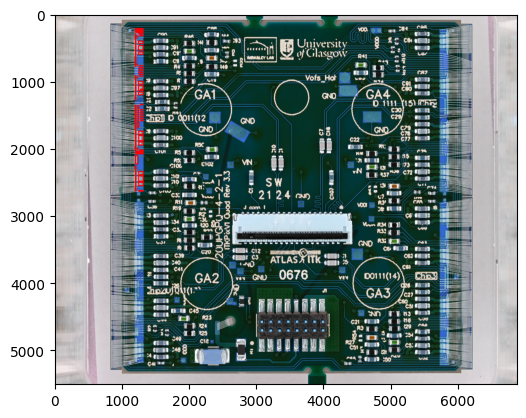

In [ ]:
## Fonction qui trouve les pads sur n'importe quelle image
## TODO : importer les positions absolues des pads depuis le ficher JSON, et dilat_ref

def find_pads(path, draw=False):
    mat, origine, dilat_measured = repere_absolu(path, draw)

    dilatation = dilat_measured/dilat_ref

    #Trouve les pads en inversant la matrice de passage
    pads_img = np.array([np.dot(np.linalg.inv(mat),dilatation*pads_nouveau_repere[i])+np.flip(np.array([origine,origine]),axis = 1) for i in range(46)]).astype(np.int16)

    img = cv.imread(path)

    #Dessin des pads
    if draw :
        for pad in pads_img :
            cv.rectangle(img,np.flip(pad[0]),np.flip(pad[1]),(255,0,0),15)

        afficher(img)

        plt.imshow(img)
        plt.show()

    return pads_img

find_pads(liste_cablees[12])